2023W 136010-1 Introduction to DH Tools and Methods - Capstone Project

Student: Bernhard Ortbauer
MatrNr: 00706604

 <h1>Uppsala Conflict Data Programme (UCDP)
 <h1>UCDP  Georeferenced  Event  Dataset  (UCDP  GED)

<b>Declaration of personal interest:
I have studied history and am generally interested in the study of international conflict. I recently read Barbara F. Walter's "How Civil Wars start", which guided me to this dataset.

<b>Description of the Dataset: </b> 
GED 23.1 is a global dataset that covers the world between 1989-01-01 and 2022-12-
31. 
 
The  purpose  of  this  dataset  is  to  provide  the  academic  community  with  the  most 
comprehensive structured event data available on organised violence in the post-1989 
world, to answer the call for geographically and temporally disaggregated data.

<b>Dataset Documentation:</b>
https://ucdp.uu.se/downloads/ged/ged231.pdf

<b>Research Question:</b>
Compare Dataset for Regions and Types of conflict.
Variables interested in: - Number of conflicts - civilian deaths - deaths overall

possible findings: 
- temporal development: identification of possible cycles
- spatial development: analyze distribution within regions, maybe identify subregions

outlook:
- try to find more datasets to expand temporal perspective and include other variables, such as type of government, democratic index, etc.

<h2>Assignment 1: Exploratory Data Analysis

First I import standard libraries and the CSV data and get an overview of the data. I will decide which columns to drop. For guidance on the variable meaning, I will use the data documentation as reference.

In [1]:
import os
import zipfile
import requests
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import geopy.geocoders as gg
import geopandas as gpd
from geopandas.tools import geocode
from shapely.geometry import LineString, MultiPolygon

import folium
from folium import Choropleth, Circle, Marker, GeoJson
from folium.plugins import HeatMap, MarkerCluster

from IPython.display import display, Image, HTML, IFrame, FileLink, FileLinks
from IPython.core.interactiveshell import InteractiveShell
import ipywidgets as widgets

from sklearn import preprocessing
from sklearn.cluster import KMeans
#InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
#plt.switch_backend('Agg')

<b>Importing the CSV data and looking at the first rows

In [3]:
df = pd.read_csv('GEDEvent_v23_1.csv')

/var/folders/tw/r1c27wl954ndkln2l33_tcyc0000gn/T/ipykernel_23443/1694437920.py:1: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('GEDEvent_v23_1.csv')


In [4]:
df.head()

,id,relid,year,active_year,code_status,type_of_violence,conflict_dset_id,conflict_new_id,conflict_name,dyad_dset_id,...,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,high,low,gwnoa,gwnob
0,244657,IRQ-2017-1-524-322,2017,1,Clear,1,259,259,Iraq: Government,524,...,2017-07-31 00:00:00.000,0,4,0,2,6,6,6,645,NaN
1,412700,IRQ-2021-1-524-145,2021,1,Clear,1,259,259,Iraq: Government,524,...,2021-08-26 00:00:00.000,13,1,141,28,183,184,171,645,NaN
2,413023,IRQ-2021-1-524-143,2021,1,Clear,1,259,259,Iraq: Government,524,...,2021-08-28 00:00:00.000,0,2,0,0,2,3,0,645,NaN
3,412909,IRQ-2021-1-524-144,2021,1,Clear,1,259,259,Iraq: Government,524,...,2021-08-29 00:00:00.000,0,0,10,0,10,10,9,645,NaN
4,132140,AFG-1989-1-411-2,1989,1,Clear,1,333,333,Afghanistan: Government,724,...,1989-01-13 00:00:00.000,6,0,0,0,6,6,6,700,NaN


In [5]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316818 entries, 0 to 316817
Data columns (total 49 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 316818 non-null  int64  
 1   relid              316818 non-null  object 
 2   year               316818 non-null  int64  
 3   active_year        316818 non-null  int64  
 4   code_status        316818 non-null  object 
 5   type_of_violence   316818 non-null  int64  
 6   conflict_dset_id   316818 non-null  int64  
 7   conflict_new_id    316818 non-null  int64  
 8   conflict_name      316818 non-null  object 
 9   dyad_dset_id       316818 non-null  int64  
 10  dyad_new_id        316818 non-null  int64  
 11  dyad_name          316818 non-null  object 
 12  side_a_dset_id     316818 non-null  int64  
 13  side_a_new_id      316818 non-null  int64  
 14  side_a             316818 non-null  object 
 15  side_b_dset_id     316818 non-null  int64  
 16  si

,id,year,active_year,type_of_violence,conflict_dset_id,conflict_new_id,dyad_dset_id,dyad_new_id,side_a_dset_id,side_a_new_id,...,event_clarity,date_prec,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,high,low,gwnob
count,316818.000000,316818.000000,316818.000000,316818.000000,316818.000000,316818.000000,316818.00000,316818.000000,316818.000000,316818.000000,...,316818.000000,316818.000000,316818.000000,316818.000000,316818.000000,316818.000000,316818.000000,316818.000000,316818.000000,6150.000000
mean,242230.897092,2010.632745,0.966703,1.435506,2819.241460,2826.008519,5896.40872,6105.962035,497.901174,497.901174,...,1.074671,1.229914,1.857167,2.306589,4.325660,2.107664,10.597081,16.131271,8.772876,457.374797
std,131299.675972,8.922432,0.179411,0.743684,5131.131651,5007.563022,6162.38452,6151.624302,1392.621010,1392.621010,...,0.262860,0.666923,55.669318,31.673231,196.059405,176.642466,273.506271,407.775376,218.429740,162.442607
min,4.000000,1989.000000,0.000000,1.000000,6.000000,205.000000,6.00000,406.000000,3.000000,3.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,133657.250000,2005.000000,1.000000,1.000000,299.000000,299.000000,735.00000,750.000000,116.000000,116.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,369.000000
50%,247543.000000,2013.000000,1.000000,1.000000,333.000000,354.000000,848.00000,999.000000,118.000000,118.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,369.000000
75%,355495.750000,2017.000000,1.000000,2.000000,432.000000,572.000000,11973.00000,11973.000000,146.000000,146.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,5.000000,5.000000,4.000000,369.000000
max,468640.000000,2022.000000,1.000000,3.000000,17446.000000,15859.000000,17446.00000,17446.000000,8586.000000,8586.000000,...,2.000000,5.000000,14162.000000,9505.000000,40000.000000,75340.000000,75340.000000,74256.000000,75482.000000,800.000000


<b>On a global level and with all variables, the dataset seems a bit overwhelming. So I will chose a list of Variables to keep. Mainly focusing on deaths and type of violence.
Here is the list of variables from the data documentation and the decision to drop or keep the respective column

Variable name | Content | Type | Keep
---|---|---|---
id | A unique numeric ID identifying each event. | integer | Keep
relid | Only used in older versions of the dataset, empty variable in the api 23.1 version, removed in the other  ormats for UCDP GED 23.1. | '' | Drop
year | The year of the event | integer | Keep
active_year | 1: if the event belongs to an active conflict/dyad/actor-year <br>0: otherwise | integer | Drop
type_of_violence | Type of UCDP conflict: <br>1: state-based conflict <br>2: non-state conflict <br>3: one-sided violence | integer | Keep
code_status | Always clear, only used for monthly releases of candidate events, only available in the api 23.1 version, removed in the other formats for UCDP GED 23.1. | string | Drop
conflict_dset_id | Only used in older versions of the dataset, exists but should not be used in the api 23.1 version, removed in the other formats for UCDP GED 23.1. | '' | Drop
conflict_new_id | A unique conflict identification code for each individual conflict in the dataset. | integer | Drop
conflict_name | Name of the UCDP conflict to which the event belongs. For non-state conflicts and one-sided violence this is the same as the dyad name. | string(9999) | Keep
dyad_dset_id | Only used in older versions of the dataset, exists but should not be used in the api 23.1 version, removed in the other formats for UCDP GED 23.1. | '' | Drop
dyad_new_id | A unique conflict identification code for each individual dyad in the dataset. | integer | Drop
dyad_name | Name of the conflict dyad creating the event. A dyad is the pair of two actors engaged in violence (in the case of one-sided violence, the perpetrator of violence and civilians). | string(9999) | Keep
side_a_dset_id | Only used in older versions of the dataset, exists but should not be used in the api 23.1 version, removed in the other formats for UCDP GED 23.1. | '' | Drop
side_a_new_id | A unique ID of side A. | integer | Drop
side_a | The name of Side A in the dyad. In state-based conflicts always a government. In one-sided violence always the perpetrating party. | string(9999) | Keep
side_b_dset_id | Only used in older versions of the dataset, exists but should not be used in the api 23.1 version, removed in the other formats for UCDP GED 23.1. | '' | Drop
side_b_new_id | A unique ID of side B. | integer | Drop
side_b | The name of Side B in the dyad. In state-based always the rebel movement or rivalling government. In one-sided violence always “civilians”. | string(9999) | Keep
number_of_sources | Number of total sources containing information for an event that were consulted. | integer | Drop
source_article | References to the names, dates and titles of the source material from which information on the event is gathered. | text | Drop
source_office | The name of the organizations publishing the source materials. | text | Drop
source_date | The dates the source materials were published on. | text | Drop
source_headline | The titles of the source materials. | text | Drop
source_original | The name or type of person or organization from which the information about the event originates in the original report. e.g. “police”, “Lt. Col. Johnson”, ”eyewitnesses”, “rebel spokesman”. | string(9999) | Drop
where_prec | The precision with which the coordinates and location assigned to the event reflects the location of the actual event. <br>1: exact location of the event known and coded. <br>2: event occurred within at maximum a ca. 25 km radius around a known point. The coded point is the known point. <br>3: only the second order administrative division where an event happened is known. That administrative division is coded with a point representing it (typically the centroid). <br>4: only the first order administrative division where an event happened is known. That administrative division is coded with a point representing it <b>(typically the centroid)</b>. <br>5: the only spatial reference for the event is neither a known point nor a known formal administrative division, but rather a linear feature (e.g. a long river, a border, a longer road or the line connecting two locations further afield than 25 km) or a fuzzy polygon without defined borders (informal regions, large radiuses etc.). A representation point is chosen for the feature and employed. <br>6: only the country where the event took place in is known. <br>7: event in international waters or airspace. | integer | Drop
where_coordinates | Name of the location to which the event is assigned. Fully standardized and normalized. | string(9999) | Keep
where_description | Comment on the location coded, sometimes left empty can include area of the capital or name of a village that has not been found | string | Keep
adm_1 | Name of the first order (largest) administrative division where the event took place | string(9999) | Keep
adm_2 | Name of the second order administrative division where the event took place |string(9999) | Keep
latitude | Latitude (in decimal degrees) | numeric(9,6) | Keep
longitude | Longitude (in decimal degrees) | numeric(9,6) | Keep
geom_wkt | An Open Geospatial Consortium textual representation of the location of each individual point. Formatted as OGC WKT (well known text) without SRID. | string(9999) | Keep
priogrid_gid | The PRIO-grid cell id (gid) in which the event took place. | integer | Drop
country | Name of the country in which the event takes place. | string(999) | Keep
country_id | Gleditsch and Ward number of the country in which the event takes place. | integer | Drop
region | Region where the event took place. One of following: {Africa, Americas, Asia, Europe, Middle East} | string(999) | Keep
event_clarity | 1 (high) for events where the reporting allows the coder to identify the event in full. <br>2 (lower) for events where an aggregation of information was already made by the source material that is impossible to undo in the coding process. Such events are described by the original source only as aggregates (totals) of multiple separate activities of fighting spanning over a longer period than a single, clearly defined day. | integer | Drop
date_prec | How precise the information is about the date of an event. <br>1: exact date of event is known; <br>2: the date of the event is known only within a 2-6 day range. <br>3: only the week of the event is known <br>4: the date of the event is known only within an 8-30 day range or only the month when the event has taken place is known <br>5: the date of the event is known only within a range longer than one month but not more than one calendar year. | integer | Drop
date_start | The earliest possible date when the event has taken place. | Date YYYY-MM-DD | Keep
date_end | The last possible date when the event has taken place. | Date YYYY-MM-DD | Keep
deaths_a | The best estimate of deaths sustained by side a. Always 0 for one-sided violence events. | integer | Keep
deaths_b | The best estimate of deaths sustained by side b. Always 0 for one-sided violence events. | integer | Keep
deaths_civilians | The best estimate of dead civilians in the event. | integer | Keep
deaths_unknown | The best estimate of deaths of persons of unknown status. | integer | Drop
best | The best (most likely) estimate of total fatalities resulting from an event. It is always the sum of deaths_a, deaths_b, deaths_civilians and deaths_unknown. | integer | Keep
high | The highest reliable estimate of total fatalities | integer | Drop
low | The lowest reliable estimate of total fatalities | integer | Drop
gwnoa | The Gleditsch and Ward number for Side A if the side is a state. Empty if Side A is not a state. | string(9999) | Drop
gwnob | The Gleditsch and Ward number for Side B if the side is a state. Empty if Side B is not a state. | string(9999) | Drop




In [6]:
select_columns = ['id', 'year', 'type_of_violence', 'conflict_name', 'dyad_name', 'side_a', 'side_b',
                  'where_coordinates', 'where_description', 'adm_1', 'adm_2', 'latitude', 'longitude', 'geom_wkt', 'country', 'region',
                  'date_start', 'date_end', 'deaths_a', 'deaths_b', 'deaths_civilians', 'best']

df_conflict = df[select_columns]
df_conflict = df_conflict.sort_values(['year', 'region', 'country'])

<b>I will change the dtype of date_start and date_end to datetime

In [7]:
df_conflict.head()
df_conflict['date_start'] = pd.to_datetime(df_conflict['date_start'])
df_conflict['date_end'] = pd.to_datetime(df_conflict['date_end'])
df_conflict.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 316818 entries, 46025 to 316711
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id                 316818 non-null  int64         
 1   year               316818 non-null  int64         
 2   type_of_violence   316818 non-null  int64         
 3   conflict_name      316818 non-null  object        
 4   dyad_name          316818 non-null  object        
 5   side_a             316818 non-null  object        
 6   side_b             316818 non-null  object        
 7   where_coordinates  316818 non-null  object        
 8   where_description  310051 non-null  object        
 9   adm_1              298979 non-null  object        
 10  adm_2              250153 non-null  object        
 11  latitude           316818 non-null  float64       
 12  longitude          316818 non-null  float64       
 13  geom_wkt           316818 non-null  obje

<b>at first I want to look at Europe to get a feeling for the data on a bit smaller scale

In [8]:
eu_conflict = df_conflict[df_conflict.region == 'Europe']
eu_conflict = eu_conflict.reset_index(drop=True)
eu_conflict.head()
eu_conflict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24029 entries, 0 to 24028
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 24029 non-null  int64         
 1   year               24029 non-null  int64         
 2   type_of_violence   24029 non-null  int64         
 3   conflict_name      24029 non-null  object        
 4   dyad_name          24029 non-null  object        
 5   side_a             24029 non-null  object        
 6   side_b             24029 non-null  object        
 7   where_coordinates  24029 non-null  object        
 8   where_description  23446 non-null  object        
 9   adm_1              13140 non-null  object        
 10  adm_2              9885 non-null   object        
 11  latitude           24029 non-null  float64       
 12  longitude          24029 non-null  float64       
 13  geom_wkt           24029 non-null  object        
 14  countr

In [9]:

def unique_col_values(df):
    for column in df:
        print("{} | {} | {}".format(
            df[column].name, len(df[column].unique()), df[column].dtype
        ))

unique_col_values(eu_conflict)

id | 24029 | int64
year | 34 | int64
type_of_violence | 3 | int64
conflict_name | 66 | object
dyad_name | 75 | object
side_a | 38 | object
side_b | 49 | object
where_coordinates | 2901 | object
where_description | 9264 | object
adm_1 | 230 | object
adm_2 | 484 | object
latitude | 2910 | float64
longitude | 2945 | float64
geom_wkt | 2997 | object
country | 23 | object
region | 1 | object
date_start | 6036 | datetime64[ns]
date_end | 6072 | datetime64[ns]
deaths_a | 133 | int64
deaths_b | 93 | int64
deaths_civilians | 130 | int64
best | 229 | int64


<b>Austria is present with one entry: the terror attack of Vienna in 2020

In [10]:
eu_conflict[eu_conflict.country == 'Austria']

,id,year,type_of_violence,conflict_name,dyad_name,side_a,side_b,where_coordinates,where_description,adm_1,...,longitude,geom_wkt,country,region,date_start,date_end,deaths_a,deaths_b,deaths_civilians,best
18660,364836,2020,3,IS - Civilians,IS - Civilians,IS,Civilians,Vienna city,"Vienna, Austria",Vienna bundesland,...,16.373724,POINT (16.373724 48.208285),Austria,Europe,2020-11-02,2020-11-02,0,0,4,4


<h3>Yearly overview on region level</h3>

<b>first i want to get a feeling for the data on a regional level. I start by analyzing over the years.

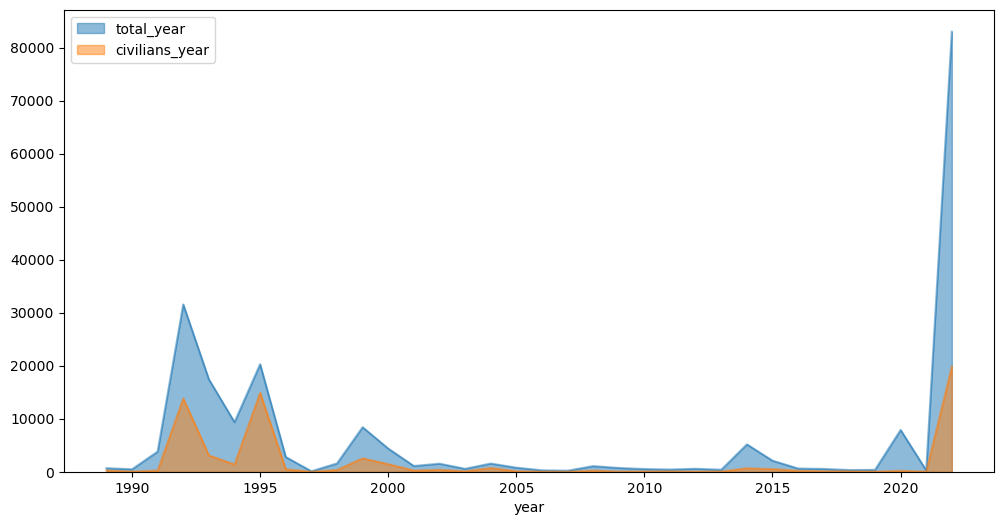

In [11]:
dths_yr = eu_conflict.groupby('year')["best"].sum().rename("total_year").reset_index()
civs_yr = eu_conflict.groupby('year')["deaths_civilians"].sum().rename("civilians_year").reset_index()
dths_yr = dths_yr.merge(civs_yr)
dths_yr.plot(x='year', kind='area', stacked=False);

<b>What we can see, is the total number of deaths escalated in the recent years (presumably Ukraine). There is a huge difference over the years in the number of fatalities and the proportion of civilians. Also interesting is the type of violence as mentioned initially.

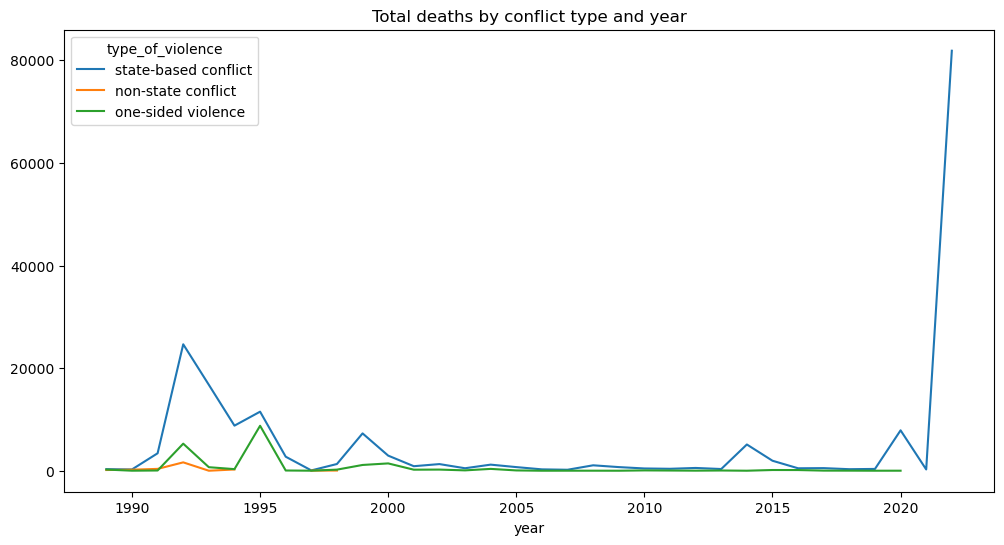

In [12]:
deaths_per_year = eu_conflict.pivot_table('best', index='year', columns='type_of_violence', aggfunc=sum).rename(columns={1: 'state-based conflict', 2: 'non-state conflict', 3: 'one-sided violence'})
deaths_per_year.head(10)
#deaths_per_year.tail()
deaths_per_year.plot(title='Total deaths by conflict type and year');

<b>What we see from the above plot, is that state-based conflicts account for the most deaths, that comes as no suprise, as those are fought with full size armies. Interested if the picture is the same when we focuse on number of events.

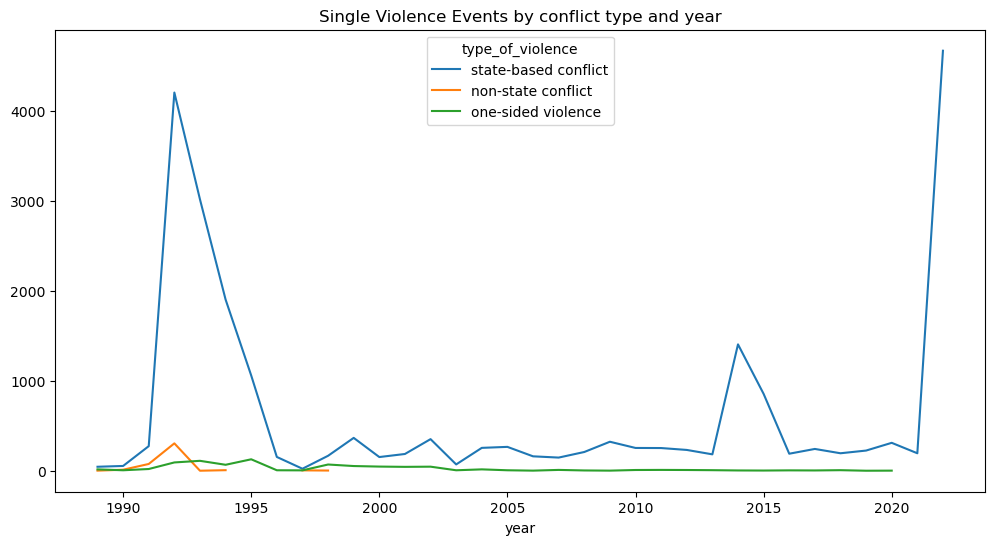

In [13]:
events_per_year = eu_conflict.pivot_table('best', index='year', columns='type_of_violence', aggfunc='count').rename(columns={1: 'state-based conflict', 2: 'non-state conflict', 3: 'one-sided violence'})
events_per_year.head(10)
#deaths_per_year.tail()
events_per_year.plot(title='Single Violence Events by conflict type and year');

<b>The numbers go also way up after 2020, but the difference to the early 90ies is not so extreme. Which indicates that todays events have more fatalities per event in average. We also see that there are throughoutonly some one-sided violence events, but compared to non state conflict, they have much higher fatality numbers. Let's see if this shows in another plot:

In [14]:
deaths_per_event_year = deaths_per_year / events_per_year
deaths_per_event_year.head(10)
#deaths_per_year.tail()


type_of_violence,state-based conflict,non-state conflict,one-sided violence
year,,,
1989,6.755556,69.500000,14.125000
1990,4.722222,16.750000,1.000000
1991,12.408759,4.723684,2.300000
1992,5.863431,5.347541,56.709677
1993,5.551724,1.000000,6.189189
1994,4.617446,34.857143,4.656716
1995,10.868744,NaN,68.460938
1996,17.753247,NaN,7.166667
1997,2.695652,5.200000,1.200000


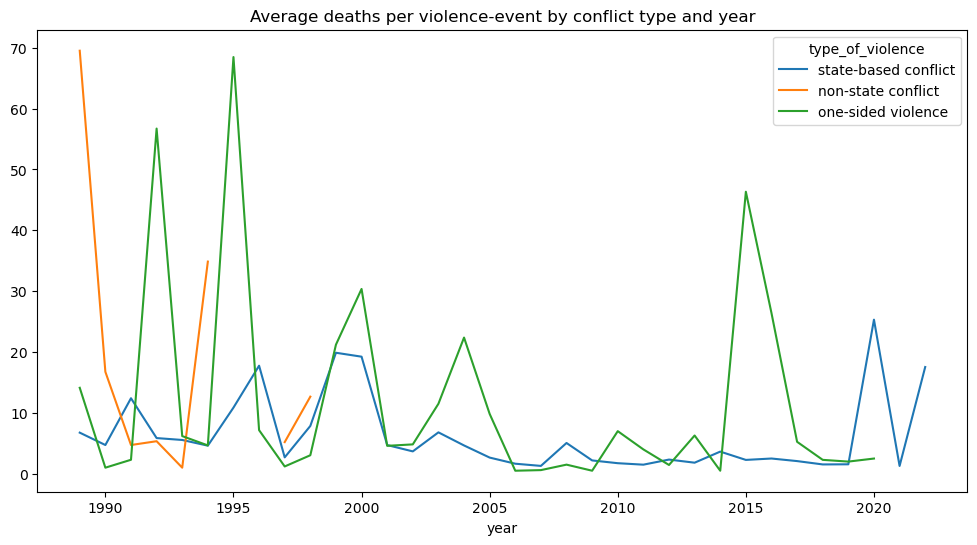

In [15]:
deaths_per_event_year.plot(title='Average deaths per violence-event by conflict type and year');

<b>This is impressive: one-sided violence seems especially prone to killing a lot of people - including genocidal events. The 1989 saw a low number of deaths and events overall, but the overall number was mainly driven by non-state conflict. This type of violence disappeared from Europe with the end of the 90ies.

Now it would be interesting, how the number of deaths per event is distributed among all events.

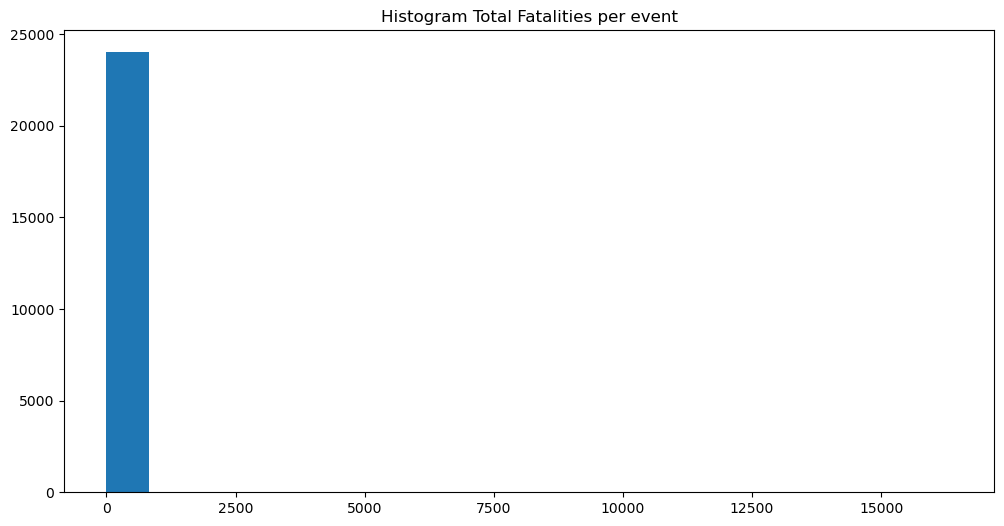

In [16]:
eu_conflict.hist('best', bins = 20)
#plt.xlim((5, 11))
#plt.ylim((0, 12))
plt.title("Histogram Total Fatalities per event")
plt.grid(False)

<b>The histogram of deaths per event shows only one bar and that at the lowest end. There are nearly 25000 violence-events with no or very few fatalities. But the x-scale goes up to 8000 fatalities. This relativates all above findings, as it seems, that the big numbers are mainly driven by a very small sample of especially deadly events. This also makes the dataset very hard to compare on a event basis. When we exclude the big bulk of smaller events with less than 200 fatalities, the picture clears up a bit. Still we have the great majority at the lower end. We see, however, that the scale even extends to 16000 fatalities in one single event (see below).

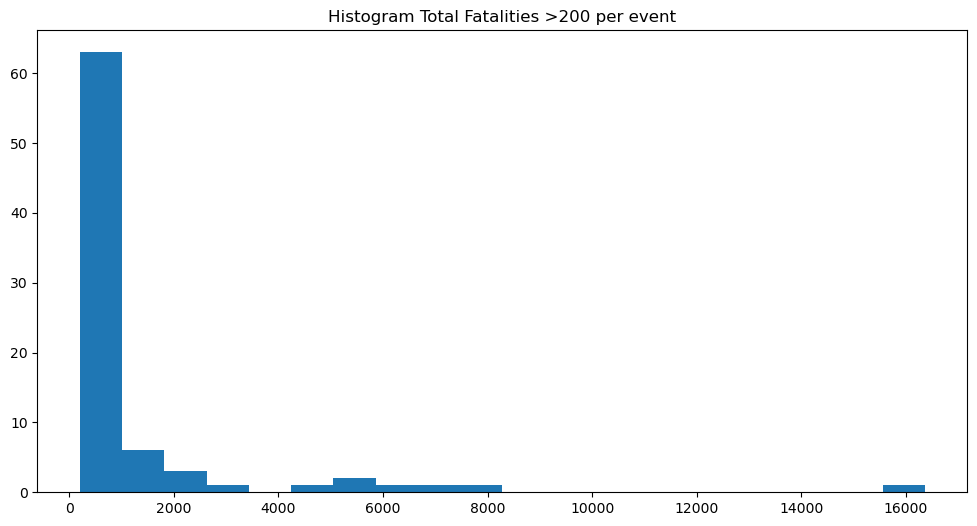

In [17]:
eu_conflict[eu_conflict.best >200].hist('best', bins = 20)
#plt.xlim((5, 11))
#plt.ylim((0, 12))
plt.title("Histogram Total Fatalities >200 per event")
plt.grid(False)

<b>Of course also the boxplot makes not a lot of sense:

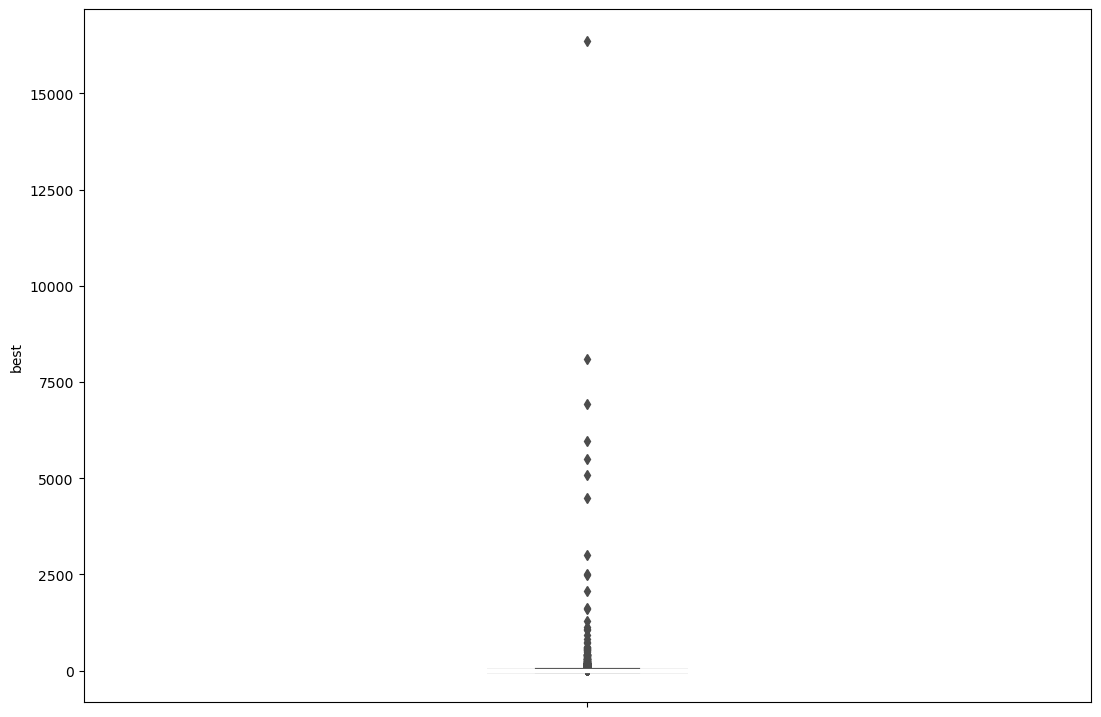

In [18]:
plt.figure(figsize=(13,9))
sns.boxplot(data = eu_conflict,
            y = 'best',
            color = 'cadetblue',
            width = 0.2,
            linewidth = 3,
            medianprops={'color':'white'});

<b>unless we log-scale y, but we got the picture anyway

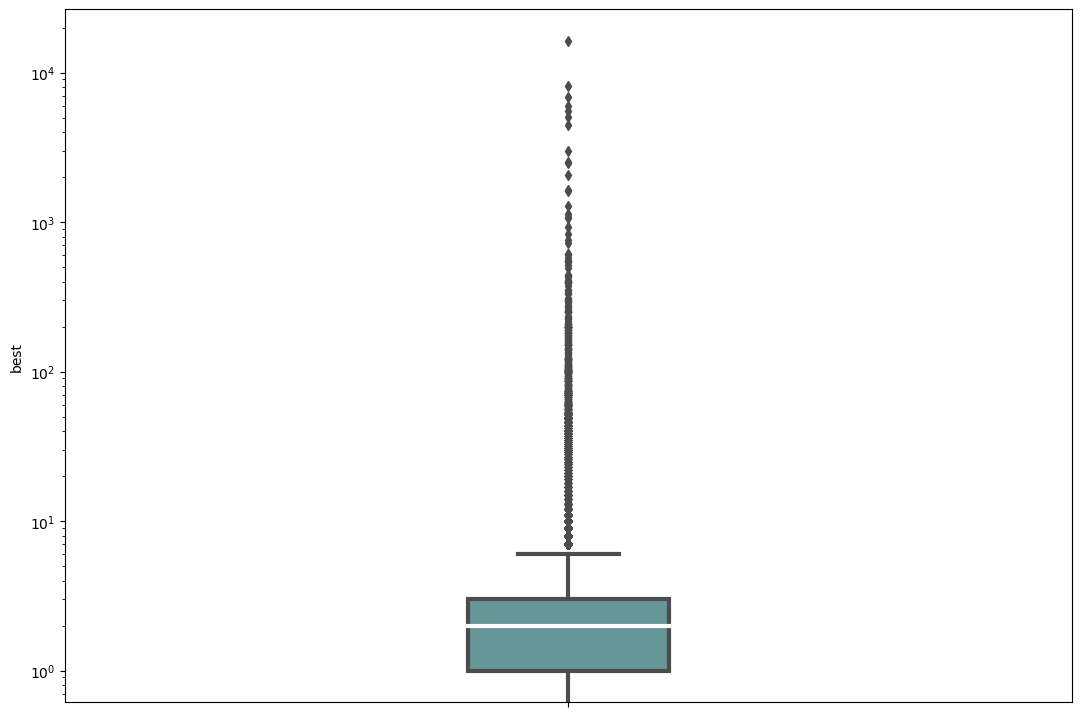

In [19]:
plt.figure(figsize=(13,9))
bx = sns.boxplot(data = eu_conflict,
            y = 'best',
            color = 'cadetblue',
            width = 0.2,
            linewidth = 3,
            medianprops={'color':'white'})
bx.set_yscale('log')

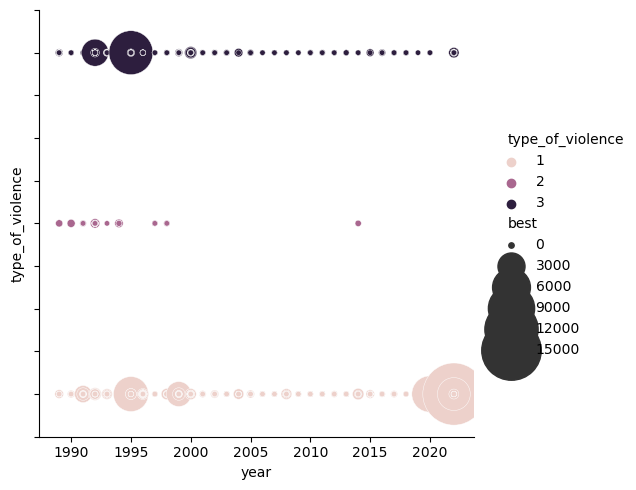

In [20]:
ax = sns.relplot(
    data=eu_conflict, x="year", y="type_of_violence",
    size="best", sizes=(15, 2000),
    hue='type_of_violence'
)
ax.set_yticklabels('')
ax.tight_layout();


<b>The plot above is more informative: state-based conflicts (1) make up for the biggest single events, the biggest after 2020. Non-state violence events (2) happen on a smaller scale, while there were very brutal one-sided events in the first half of the 90ies. The biggest in 1995.

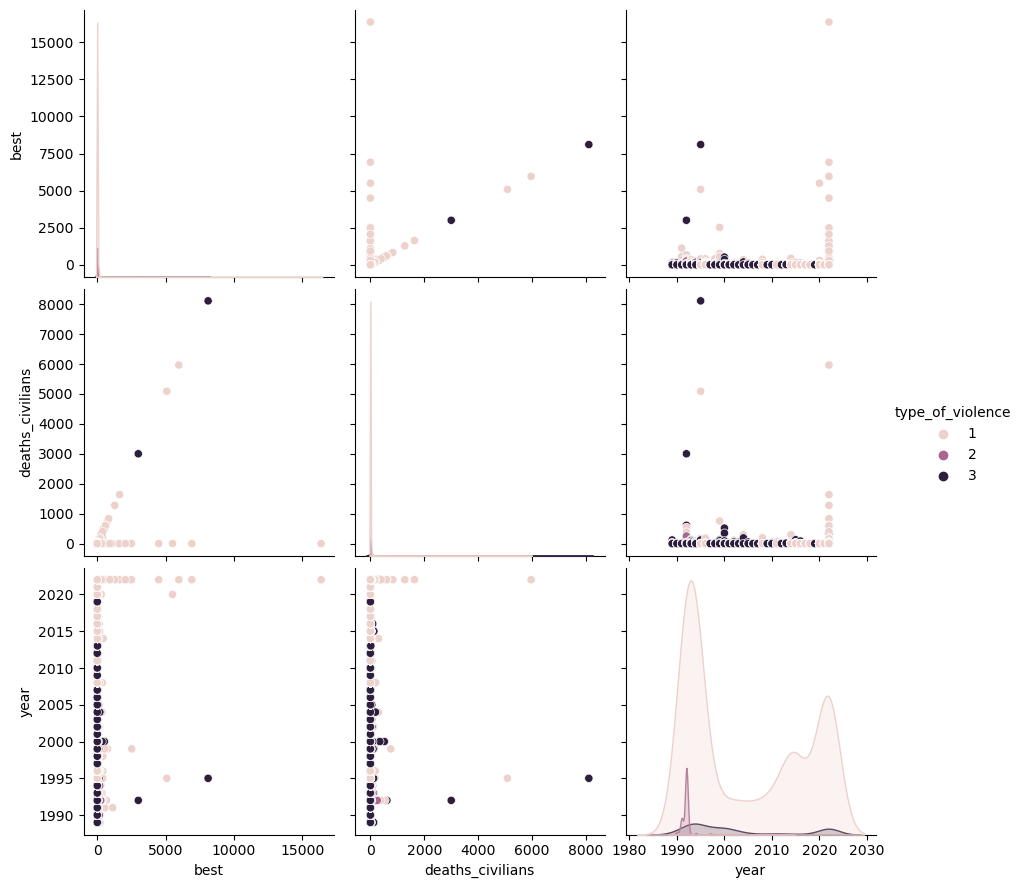

In [21]:
select_columns = ['type_of_violence','best','deaths_civilians',
                   'country', 'year']

sns.pairplot(eu_conflict[select_columns], hue='type_of_violence', height=3, diag_kws={'bw_method': 0.2});

<h3>Geographical distribution</h3>
<b>Now I will try to add the aerial dimension to the temporal analysis, I have done so far. Therefore I will furthre reduce the dataset.

In [22]:
select_columns = ['year', 'type_of_violence', 'where_description', 'latitude', 'longitude', 'country',
                  'deaths_civilians', 'best']

eu_conf_reduced = eu_conflict[select_columns]
eu_conf_reduced

,year,type_of_violence,where_description,latitude,longitude,country,deaths_civilians,best
0,1989,1,Hannover town,52.370520,9.733220,Germany,0,1
1,1989,1,near Wildenrath town,51.126010,6.190850,Germany,1,2
2,1989,1,Transylvanian city of Timisoara,45.759722,21.230000,Romania,0,0
3,1989,1,Timisoara,45.759722,21.230000,Romania,0,0
4,1989,1,NaN,46.000000,25.000000,Romania,0,196
...,...,...,...,...,...,...,...,...
24024,2022,1,the populated centre Donetskyy,48.700000,38.671526,Ukraine,0,1
24025,2022,1,the area near the Holubivske village,48.690674,38.640518,Ukraine,0,1
24026,2022,1,"near the village of Pionerskoye, 7 km from the...",48.572975,39.577325,Ukraine,0,0
24027,2022,1,in the Lugansk region,48.920000,39.020000,Ukraine,0,1


<b>I want to create a map, where i can show a heatmap weighted with the deaths in a location. Therefore I will normalise the total number of deaths per event on the total number of deaths in the respective year.

In [23]:

dths_yr = eu_gb_yr_red = eu_conf_reduced.groupby('year')["best"].sum().rename("best_year").reset_index()
civs_yr = eu_gb_yr_red = eu_conf_reduced.groupby('year')["deaths_civilians"].sum().rename("civilians_year").reset_index()
eu_conf_reduced = eu_conf_reduced.merge(dths_yr)
eu_conf_reduced = eu_conf_reduced.merge(civs_yr)
eu_conf_reduced['best_weight'] = eu_conf_reduced['best'] / eu_conf_reduced['best_year']
eu_conf_reduced['civ_weight'] = eu_conf_reduced['deaths_civilians'] / eu_conf_reduced['civilians_year'] 
eu_conf_reduced = eu_conf_reduced.drop(columns=['deaths_civilians', 'best', 'best_year', 'civilians_year'])

    

<b>a heatmap with time needs a list of weighted coordinates. Therefore i group the weights per year by both lat and lon and store the results in lists.

In [24]:
data = []

for yr in eu_conf_reduced['year'].sort_values().unique():
    data.append(eu_conf_reduced.loc[eu_conf_reduced['year'] == yr,
                                    ['latitude', 'longitude', 'best_weight']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist())
    
data

[[[37.178354, -3.599201, 0.0014947683109118087],
  [39.208889, 48.497222, 0.0014947683109118087],
  [39.81744, 46.75318, 0.0],
  [40.0, 46.583333, 0.06278026905829596],
  [40.412752, -3.707721, 0.008968609865470852],
  [40.5, 71.25, 0.14499252615844543],
  [41.3125, 69.3903, 0.0],
  [41.716667, 44.783333, 0.029895366218236172],
  [43.260919, -2.938764, 0.005979073243647235],
  [43.313556, -1.981855, 0.0014947683109118087],
  [43.338685, -1.793086, 0.004484304932735426],
  [43.366667, -3.016667, 0.0029895366218236174],
  [43.900833, 25.973889, 0.004484304932735426],
  [44.435715, 26.102504, 0.0523168908819133],
  [44.571111, 26.085, 0.07772795216741404],
  [45.759722, 21.23, 0.1883408071748879],
  [46.0, 25.0, 0.2929745889387145],
  [46.166667, 21.316667, 0.005979073243647235],
  [46.766667, 23.583333, 0.04783258594917788],
  [51.12601, 6.19085, 0.0029895366218236174],
  [51.22322, 1.40432, 0.016442451420029897],
  [52.37052, 9.73322, 0.0014947683109118087],
  [54.08333, -6.6, 0.0014947

<b>I chose a dark background map to better see the heatmap

In [25]:
index = eu_conf_reduced['year'].sort_values().unique().tolist()
tiles = 'https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}{r}.png'
attr = '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>'
m = folium.Map([48.0, 5.0], zoom_start=4, tiles=tiles, attr=attr, max_zoom=4, min_zoom=4)

hm = folium.plugins.HeatMapWithTime(data, index=index, auto_play=False)

hm.add_to(m)

m

<b>Looking at the series we can see that deadly events mostly disappeared from Western Europe with the 90ies. The balkan is a hotspot until 2001 and disappears afterwards. The caucasus region is in almost constant conflict. In 2022 we can clearly see the Ukrainian border areas as the main areas, leaving no room for other "heat" anywhere else on the map.

<h3>Analysis on a single event basis</h3>
<b>I will continue exploring on a much smaller scale and look at a single event. I am interested in the single event withe the most civilian deaths.

In [26]:
civil_worst = eu_conflict[eu_conflict.deaths_civilians == eu_conflict['deaths_civilians'].max()]
civil_worst

,id,year,type_of_violence,conflict_name,dyad_name,side_a,side_b,where_coordinates,where_description,adm_1,...,longitude,geom_wkt,country,region,date_start,date_end,deaths_a,deaths_b,deaths_civilians,best
11088,199704,1995,3,"Serbian irregulars, Serbian Republic of Bosnia...","Serbian irregulars, Serbian Republic of Bosnia...","Serbian irregulars, Serbian Republic of Bosnia...",Civilians,Srebrenica town,Srebrenica town,NaN,...,19.296944,POINT (19.296944 44.106389),Bosnia-Herzegovina,Europe,1995-07-10,1995-07-11,0,0,8106,8106


<b>As I have expected it is the genocidal event in Srebrenica in 1995. Let's map it out.

In [27]:
geolocator = gg.Nominatim(user_agent="test_application") #https://operations.osmfoundation.org/policies/nominatim/

In [28]:
address = civil_worst.where_description.values[0]
location = geolocator.geocode(address)
print(location.address)
print(location.longitude)
print(location.latitude)
print(civil_worst.where_coordinates.values[0])
print(civil_worst.longitude.values[0])
print(civil_worst.latitude.values[0])
print(civil_worst.geom_wkt.values[0])
print(civil_worst.date_start.values[0])
print(civil_worst.date_end.values[0])

Srebrenica, Opština Srebrenica, Република Српска / Republika Srpska, 75430, Bosna i Hercegovina / Босна и Херцеговина
19.2952783
44.1063188
Srebrenica town
19.296944
44.106389
POINT (19.296944 44.106389)
1995-07-10T00:00:00.000000000
1995-07-11T00:00:00.000000000


<b>We see that all stored positional information refers to the same coordinates so we can use any of them.

<b>I want a vector shape of Bosnia to overlay my map with. Therefore I import a geojson file with all countries. This might come handy later on and try to isolate Bosnia.

In [29]:
gdf = gpd.read_file('countries.geojson').set_index('ADMIN')
gdf

,ISO_A3,ISO_A2,geometry
ADMIN,,,
Aruba,ABW,AW,"MULTIPOLYGON (((-69.99694 12.57758, -69.93639 ..."
Afghanistan,AFG,AF,"MULTIPOLYGON (((71.04980 38.40866, 71.05714 38..."
Angola,AGO,AO,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -..."
Anguilla,AIA,AI,"MULTIPOLYGON (((-63.03767 18.21296, -63.09952 ..."
Albania,ALB,AL,"MULTIPOLYGON (((19.74777 42.57890, 19.74601 42..."
...,...,...,...
Samoa,WSM,WS,"MULTIPOLYGON (((-171.57002 -13.93816, -171.564..."
Yemen,YEM,YE,"MULTIPOLYGON (((53.30824 12.11839, 53.31027 12..."
South Africa,ZAF,ZA,"MULTIPOLYGON (((37.86378 -46.94085, 37.83644 -..."


<Axes: >

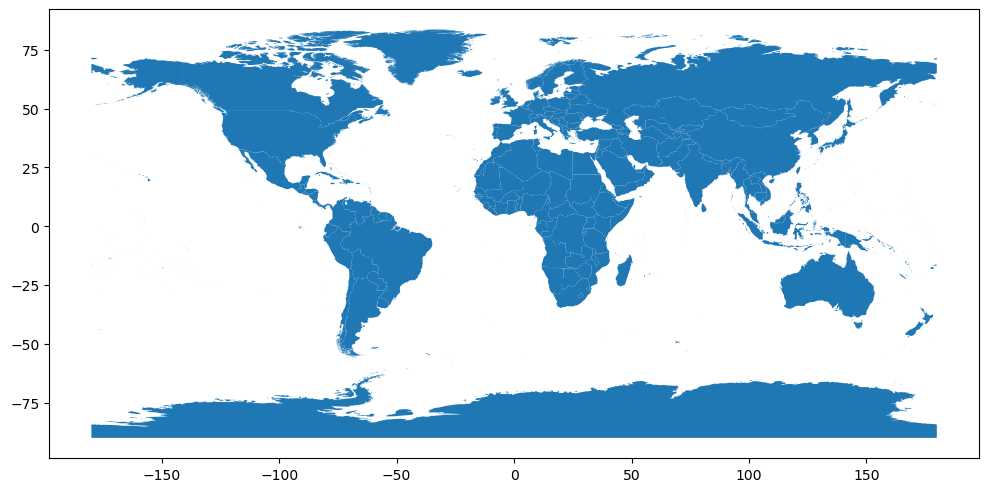

In [30]:

gdf.plot()

<Axes: >

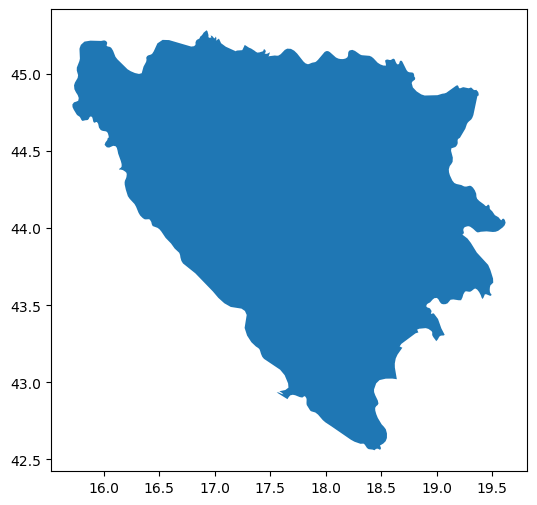

In [31]:
bosnia = gdf[gdf.index == 'Bosnia and Herzegovina']
bosnia.plot()

<b>Now lets pin down Srebrenica on a map.

In [32]:
tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}'
attr = 'Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community'
srebrenica = folium.Map([location.latitude, location.longitude], zoom_start=15, tiles=tiles, attr=attr)
info = f"{address}\nDate: {civil_worst.date_start.values[0]} \nDead Civilians: {civil_worst.deaths_civilians.values[0]}"
tooltip = "Click me!"
folium.Marker([location.latitude, location.longitude], popup=info, tooltip=tooltip, icon=folium.Icon(color="red", icon="info-sign")).add_to(srebrenica)
srebrenica

<b>When we underly an aerial photograph, we see that the coordinates point to the town center, but not to the place of the massacre itself. I will add this here manually, but this will not be feasible for the whole dataset. On a single event basis we could measure the geolocation accuracy.

In [33]:
tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}'
attr = 'Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community'
srebrenica = folium.Map([location.latitude, location.longitude], zoom_start=13, tiles=tiles, attr=attr)
info = f"{address}\nDate: {civil_worst.date_start.values[0]} \nDead Civilians: {civil_worst.deaths_civilians.values[0]}"
folium.Marker([location.latitude, location.longitude], popup=info, icon=folium.Icon(color="red", icon="info-sign")).add_to(srebrenica)
folium.Marker([44.15622017651065, 19.303108942357685], popup='location of massacre', icon=folium.Icon(color="black", icon="info-sign")).add_to(srebrenica)
srebrenica

<b>To make use of the vector layer, let's move the map to a bigger scale:

In [34]:
#url = ("https://raw.githubusercontent.com/python-visualization/folium/master/examples/data")

#antarctic_ice_edge = f"{url}/antarctic_ice_edge.json"
#antarctic_ice_shelf_topo = f"{url}/antarctic_ice_shelf_topo.json"


tiles = 'https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png'
attr = 'Map data: &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, <a href="http://viewfinderpanoramas.org">SRTM</a> | Map style: &copy; <a href="https://opentopomap.org">OpenTopoMap</a> (<a href="https://creativecommons.org/licenses/by-sa/3.0/">CC-BY-SA</a>)'
m = folium.Map([location.latitude, location.longitude], zoom_start=8, tiles=tiles, attr=attr)
info = f"{address}\nDate: {civil_worst.date_start.values[0]} \nDead Civilians: {civil_worst.deaths_civilians.values[0]}"
#tooltip = "Click me!"
folium.Marker([location.latitude, location.longitude], popup=info, tooltip=tooltip, icon=folium.Icon(color="red", icon="info-sign")).add_to(m)
folium.GeoJson(bosnia, name="geojson", color='blue').add_to(m)
#folium.TopoJson(json.loads(requests.get(antarctic_ice_shelf_topo).text), "objects.antarctic_ice_shelf", name="topojson",).add_to(m)
folium.LayerControl().add_to(m)
m

<h3>Analysis on a conflict basis</h3>
<b>Next I will move the focus of the analysis to a single conflict. Most probably I will chose the end of the Troubles in Northern Ireland. But let's first see, which countries are most affected in terms of civilian loss...

In [35]:
deaths_per_year = eu_conflict.pivot_table('deaths_civilians', index='country', columns='year', aggfunc=sum)
deaths_per_year


year,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
country,,,,,,,,,,,,,,,,,,,,,
Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Armenia,NaN,NaN,NaN,44.0,17.0,0.0,1.0,NaN,NaN,NaN,...,0.0,NaN,12.0,0.0,NaN,0.0,1.0,5.0,0.0,2.0
Austria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN
Azerbaijan,NaN,NaN,0.0,920.0,56.0,10.0,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,10.0,2.0,0.0,1.0,142.0,12.0,3.0
Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,32.0,NaN,1.0,NaN,NaN,NaN,NaN
Bosnia-Herzegovina,NaN,NaN,NaN,11795.0,2719.0,1241.0,14433.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Croatia,NaN,NaN,NaN,22.0,58.0,NaN,171.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
France,NaN,NaN,NaN,0.0,NaN,NaN,8.0,0.0,NaN,NaN,...,NaN,NaN,130.0,87.0,0.0,9.0,NaN,NaN,NaN,NaN
Georgia,NaN,NaN,0.0,30.0,204.0,NaN,52.0,NaN,0.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<b>Northern Ireland falls under the United Kingdom. Interesting enough that in the recorded period no civil fatalities were recorded in Ireland. It also makes me shivering how much Bosnia has suffered proportionately. This calls for another plot, maybe a pie chart?:

<Axes: >

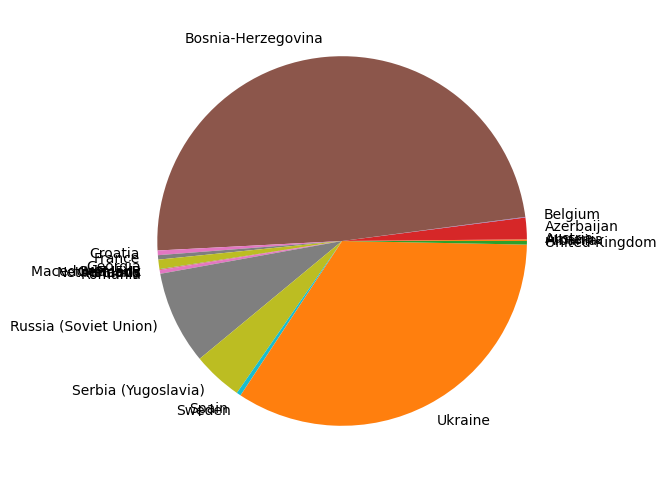

In [36]:
civ_per_country = deaths_per_year.sum(axis=1)
civ_per_country.plot(kind='pie')

<b>Unbelievable.<br>
Now I move on to Northern Ireland and the IRA

<h2>Global Analysis

In [37]:
select_columns = ['year', 'type_of_violence', 'where_description', 'latitude', 'longitude', 'country',
                  'deaths_civilians', 'best']

eu_conf_reduced = eu_conflict[select_columns]
eu_conf_reduced

,year,type_of_violence,where_description,latitude,longitude,country,deaths_civilians,best
0,1989,1,Hannover town,52.370520,9.733220,Germany,0,1
1,1989,1,near Wildenrath town,51.126010,6.190850,Germany,1,2
2,1989,1,Transylvanian city of Timisoara,45.759722,21.230000,Romania,0,0
3,1989,1,Timisoara,45.759722,21.230000,Romania,0,0
4,1989,1,NaN,46.000000,25.000000,Romania,0,196
...,...,...,...,...,...,...,...,...
24024,2022,1,the populated centre Donetskyy,48.700000,38.671526,Ukraine,0,1
24025,2022,1,the area near the Holubivske village,48.690674,38.640518,Ukraine,0,1
24026,2022,1,"near the village of Pionerskoye, 7 km from the...",48.572975,39.577325,Ukraine,0,0
24027,2022,1,in the Lugansk region,48.920000,39.020000,Ukraine,0,1
